<div class="alert alert-block alert-info"><h3>IFN619 Data Analysis for Strategic Decision Making - Assignment 1 Part B</h4></div>

In [1]:
# import the library for both Q2 and Q3

# for data loading and cleaning
import numpy as np                  
import pandas as pd             
import sys
!{sys.executable} -m pip install nltk
import nltk
from nltk.corpus import stopwords
from collections import Counter

# for Bayesan Networks (BNs)
import os
import math
import pyAgrum as bn_graphs
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC

# for Topic Classification and Topic Modelling
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import GaussianNB       # Naive Bayes Classifier based on a Gaussian Distribution
from sklearn.naive_bayes import MultinomialNB    # Naive Bayes Classifier based on a Multinomial Distribution
from pprint import pprint
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
import pickle

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# for Visualisation
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns           
sns.set()
!{sys.executable} -m pip install WordCloud
from wordcloud import WordCloud
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Question 2
What do housing-market indicators say about the socio-economic conditions in different geographical locations, and how can they be used to provide forecasts of future economic conditions?  

<img src="img/house.jpg" />

## 1. Introduction
Lee is a CEO of the Chinese investment company which is focusing on real estate investment in China. The company achieved a great success in their investments in China market over the last 5 years. In 2020, Lee would like to expand their business to overseas. However, the travelling plan for market research and investigation is limited due to the outbreak of COVID-19 around the world. Lee still expects to know if the economic recession will affect the housing price in different countries. As he known, the unemployment rate is rapidly increasing during this period, so he is more interested in how does the unemploymnet rate impact the housing prices and how do the housing prices reflect the economic conditions, so that he could make a decision for his following investment strategies overseas.       
As a member of the investment analysis team, we are provided the data from G7 coutries and Australia to solve these problems.

### 1.1 Scope
- Only G7 countries and Australia will be covered in this analysis given the provided data.  
- The elements consist of housing prices index (HPI), the unemployment rate, the interest rate, GDP and CPI only as provided in the data.

### 1.2 Stakeholder(s)
Chinese investment company which wants to invest in real estate overseas.

### 1.3 Questions
- Will the economic recession affect the housing price in different countries?
- Do the house prices reflect the socio-economic conditions in different countries and how?
- Does the unemployment rate impact on the housing market and how?
- Can the housing-market indicators be used to forecast the future economic conditions and how?

### 1.4 Approach

<img src="img/process.png"/>
<center>source: ifn619 lecture</center>

## 2. Data

### 2.1 Collect / Load Data
The Data provided in this analysis is collected from [OECD](https://en.wikipedia.org/wiki/OECD) (Organisation for Economic Co-operation and Development): https://data.oecd.org/ 
- [Norminal Housing Prices (HPI)](https://data.oecd.org/price/housing-prices.htm)(Index with base year 2015)
- [Inflation (CPI)](https://data.oecd.org/price/inflation-cpi.htm#indicator-chart)(annual growth rate %)
- [Long-term Interest Rate (Interest Rate)](https://data.oecd.org/interest/long-term-interest-rates.htm)(% per annum)
- [Quarterly GDP (GDP)](https://data.oecd.org/gdp/quarterly-gdp.htm#indicator-chart)(% change, previous period)
- [Unemployment Rate](https://data.oecd.org/unemp/unemployment-rate.htm#indicator-chart)(% of labor force)


OECD, as an intergovernmental organisation, is regared as a trustworthy source of the data in this analysis with good data quality which will lead a more effective analysis here.

In [2]:
# load the data
eco = pd.read_csv("RawData/EcoData.csv")
eco = eco.round(2)
eco

,COUNTRY,YEAR,QR,UNEMP,INTRATE,GDP,CPI,HPI
0,AUS,1999,Q4,6.63,6.63,1.70,1.92,32.19
1,AUS,2000,Q1,6.65,6.90,0.38,2.80,32.91
2,AUS,2000,Q2,6.30,6.30,0.92,3.08,33.55
3,AUS,2000,Q3,5.99,6.18,0.19,6.11,33.62
4,AUS,2000,Q4,6.17,5.88,-0.38,5.79,34.31
...,...,...,...,...,...,...,...,...
643,USA,2018,Q4,3.80,3.03,0.27,2.20,122.25
644,USA,2019,Q1,3.87,2.65,0.77,1.64,123.93
645,USA,2019,Q2,3.63,2.33,0.50,1.81,125.36
646,USA,2019,Q3,3.63,1.80,0.52,1.76,126.88


In [3]:
# get the dimensions of your dataset
dimensions = eco.shape

print( 'General size of the dataset: ' + str( dimensions ))

# extract the number of rows and columns from your data
num_rows = dimensions[0]
num_col  = dimensions[1]
print('The dataset has ' + str( num_rows ) + ' rows and ' + str( num_col ) + ' columns.' )


General size of the dataset: (648, 8)
The dataset has 648 rows and 8 columns.


In [4]:
# which years are covered in this dataset?
year = eco.loc[:, "YEAR"].unique()
print(year)

[1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019]


### 2.2 Data Cleaning

In [5]:
# to make the country name more readable
country =set(eco.COUNTRY)
eco.replace({'AUS':'Australia','CAN':'Canada',
             'DEU':'Germany','FRA':'France',
             'GBR':'United Kingdom','ITA':'Italy',
            'JPN':'Japan','USA':'United States'},inplace=True)

In [6]:
country =set(eco.COUNTRY)
print("There are total "+str(len(country))+" countries. \nThey are "+str(country))

There are total 8 countries. 
They are {'France', 'Canada', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States', 'Australia'}


More data cleaning will be executed as required by the analysis and visualisation in the following sections.

## 3. Data Re-Cleaning, Analysis & Visualisation

As there are different requirements of data cleaning for the analysis, to make it clearer to understand, the following analysis are orgnised in order as below,
1) **HPI (House Price Index) Analysis** by country groups: data re-cleaning -> analysis & visualisation   
2) **Causal Analysis:** data re-cleaning -> data modelling -> analysis & visualisation

### 3.1 HPI Analysis
Firstly, we will analyse the housing price trend in these countries.

#### 3.1.1 Data Re-cleaning

In [7]:
# we're going to generalise the data into years 
# and then have a overview of the housing-market in these year by plot.
annual_data=eco.groupby(['YEAR','COUNTRY']).mean()
annual_data.to_csv('annual_data.csv')
annual_data=pd.read_csv('annual_data.csv')
annual_data

,YEAR,COUNTRY,UNEMP,INTRATE,GDP,CPI,HPI
0,1999,Australia,6.6300,6.6300,1.7000,1.9200,32.190000
1,1999,Canada,6.9700,6.0900,1.4100,2.3700,38.940000
2,1999,France,NaN,5.2800,1.3700,0.9900,46.500000
3,1999,Germany,8.2200,5.1600,0.7900,0.9500,84.370000
4,1999,Italy,11.0700,5.3800,1.5000,2.0900,66.430000
...,...,...,...,...,...,...,...
163,2019,Germany,3.1400,-0.2500,0.1175,1.4450,128.080000
164,2019,Italy,9.9500,1.9525,0.0250,0.6125,98.516667
165,2019,Japan,2.3600,-0.1100,-0.1675,0.4775,108.652500
166,2019,United Kingdom,3.7375,0.9350,0.2625,1.7500,116.945000


In [8]:
# change the type of the "YEAR" for plot
annual_data['YEAR'] = pd.to_datetime(annual_data['YEAR'].astype(str), format='%Y')

#### 3.1.2 Analysis & Visualisation

Text(0.5, 0, 'Year')

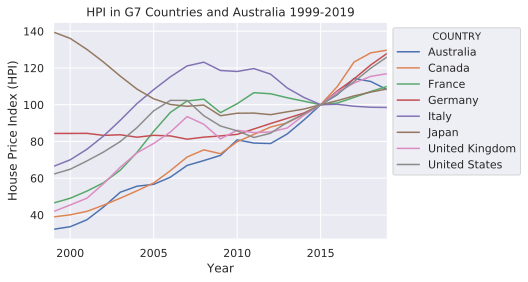

In [9]:
annual_hpi = annual_data.groupby(['YEAR','COUNTRY'])['HPI'].mean().unstack()
plot = annual_hpi.plot(title = 'HPI in G7 Countries and Australia 1999-2019')
plot.get_legend().set_bbox_to_anchor((1, 1))
plot.set_ylabel('House Price Index (HPI)')
plot.set_xlabel('Year')

In [10]:
#HPI gathered at the same point in 2015 because the index data was collected with the base year 2015 as mentioned at the beginning.

Here above, we got a general view of the housing price trend from 1999 to 2019. But the lines are complex to interpret in this plot. So how about trying plot it by country groups?  

We divide these 8 countries into 3 groups:
- Commonwealth countries: Australia, Canada, UK
- European countries: France, Germany, Italy
- Others: US, Japan

Let's see..

Text(0.5, 0, 'Year')

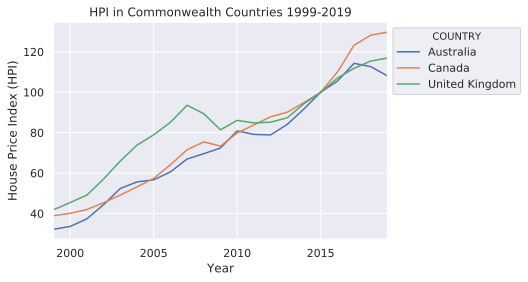

In [11]:
comm = annual_data.loc[annual_data['COUNTRY'].isin(['Australia','Canada','United Kingdom'])]
comm_hpi = comm.groupby(['YEAR','COUNTRY'])['HPI'].mean().unstack()
comm_plot = comm_hpi.plot(title = 'HPI in Commonwealth Countries 1999-2019')
comm_plot.get_legend().set_bbox_to_anchor((1, 1))
comm_plot.set_ylabel('House Price Index (HPI)')
comm_plot.set_xlabel('Year')

<div class="alert alert-block alert-success">
<b>Insight Note:</b> Housing price indexes in commonwealth countries were mostly in the similar pattern from 1999 to 2017, but Australia went to a different direction around 2018, the HPI increased in Canada and UK while it decreased in Australia mainly driven by the price drops in Sydney and Melbourne. The decreasing trend was due to the decreased investors' demand. However, the changes might differ across the nation as explained in The Guardian (e.g. the house price had a rapid increase in Hobart at that time.)
    </div>

[Sydney and Melbourne housing price falls reach lower end of market](https://www.theguardian.com/australia-news/2018/dec/11/sydney-and-melbourne-housing-price-falls-reach-lower-end-of-market)

How were the HPIs going in European countries?

Text(0.5, 0, 'Year')

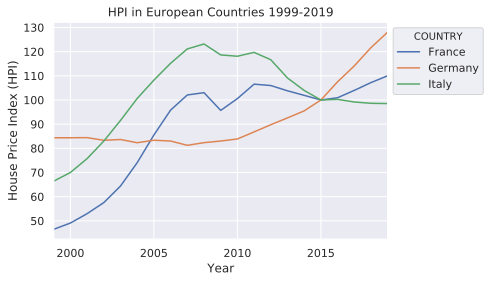

In [12]:
euro = annual_data.loc[annual_data['COUNTRY'].isin(['France','Germany','Italy'])]
eu_hpi = euro.groupby(['YEAR','COUNTRY'])['HPI'].mean().unstack()
eu_plot = eu_hpi.plot(title = 'HPI in European Countries 1999-2019')
eu_plot.get_legend().set_bbox_to_anchor((1, 1))
eu_plot.set_ylabel('House Price Index (HPI)')
eu_plot.set_xlabel('Year')

<div class="alert alert-block alert-success">
<b>Insight Note:</b> The pattern in France and Italy was a bit similar during 1999-2015 but were poles apart from 2015, while the house prices in Germany kept increasing from 1999 and shown a strong rise from 2015 due to the unique real estate financial policies and sophisticated rental market (Voigtländer, 2014).
    </div>

How about other countries in this dataset?

Text(0.5, 0, 'Year')

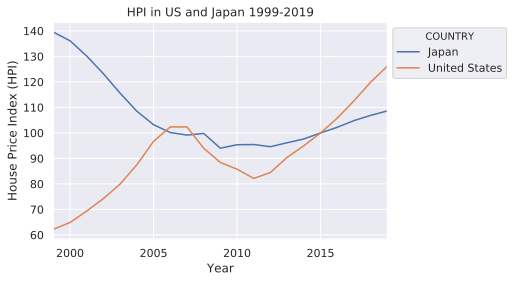

In [13]:
others = annual_data.loc[annual_data['COUNTRY'].isin(['United States','Japan'])]
oth_hpi = others.groupby(['YEAR','COUNTRY'])['HPI'].mean().unstack()
oth_plot = oth_hpi.plot(title = 'HPI in US and Japan 1999-2019')
oth_plot.get_legend().set_bbox_to_anchor((1, 1))
oth_plot.set_ylabel('House Price Index (HPI)')
oth_plot.set_xlabel('Year')

<div class="alert alert-block alert-success">
<b>Insight Note:</b> 
    <li>HPI has not been stable in the US since 1999, but it can be easily associated with the Global Financial Crisis (GFC) between 2007 to 2009 because of the housing bubble, and the house price continued to decline till 2011 reflected the huge impacts of GFC. However, there has been a sustainable growth since 2012 which might be attributed from the fiscal stimulus. But no one will know if there will be another housing bubble then.
    <li>The drop of the house price in Japan started from 1999 should be traced back to its "Lost Decade" from 1991, but it seems there was a sign of recovery from 2012. 
    </div>

[The Global Financial Crisis](https://www.rba.gov.au/education/resources/explainers/pdf/the-global-financial-crisis.pdf?v=2020-04-21-01-30-03)<br>
[Japan's Lost Decade](https://www.adb.org/sites/default/files/publication/159841/adbi-wp521.pdf)

We could have some insights about how HPI reflects the general socio-economic conditions as above, what are other indicators such as unemployment rate, interest rate, GDP and CPI saying about the economic conditions compared to HPI in different countries? 

### 3.2 Causul Analysis
To discover what is the relationship between the indicators, how does the unemployment rate affect the housing market and figure out if the indicators involved in this analysis can forecast the future economic conditions. The causal analysis is conducted in this part by building a [Bayesian Network](https://www.bayesserver.com/docs/introduction/bayesian-networks).<br>The **Bayesian Network** in this part could help us to make inferences to estimate the indicators' impacts by representing a probabilistic causal model between each indicator.

#### 3.2.1 Data Re-cleaning
More data cleaning is needed as we are going to figure out how will HPI changes be affected by or reflect other indicators' changes.

In [14]:
# calculate the changes of the indicator from previous quarter
# as GDP is decribing the % of changes compared to previous period, so no need to do this for GDP
eco1 = eco.drop(['COUNTRY','YEAR','QR','GDP'],axis=1)
eco_diff = eco1.diff()
eco_diff

,UNEMP,INTRATE,CPI,HPI
0,NaN,NaN,NaN,NaN
1,0.02,0.27,0.88,0.72
2,-0.35,-0.60,0.28,0.64
3,-0.31,-0.12,3.03,0.07
4,0.18,-0.30,-0.32,0.69
...,...,...,...,...
643,0.03,0.10,-0.44,1.55
644,0.07,-0.38,-0.56,1.68
645,-0.24,-0.32,0.17,1.43
646,0.00,-0.53,-0.05,1.52


In [15]:
# make the new dataframe filled with changes of each indicator from previous quarter (e.g. 2000/Q1-1999/Q4)
eco2 = eco.drop(['UNEMP','INTRATE','CPI','HPI'],axis=1)
new_eco = pd.concat([eco2,eco_diff],axis=1)
new_eco

,COUNTRY,YEAR,QR,GDP,UNEMP,INTRATE,CPI,HPI
0,Australia,1999,Q4,1.70,NaN,NaN,NaN,NaN
1,Australia,2000,Q1,0.38,0.02,0.27,0.88,0.72
2,Australia,2000,Q2,0.92,-0.35,-0.60,0.28,0.64
3,Australia,2000,Q3,0.19,-0.31,-0.12,3.03,0.07
4,Australia,2000,Q4,-0.38,0.18,-0.30,-0.32,0.69
...,...,...,...,...,...,...,...,...
643,United States,2018,Q4,0.27,0.03,0.10,-0.44,1.55
644,United States,2019,Q1,0.77,0.07,-0.38,-0.56,1.68
645,United States,2019,Q2,0.50,-0.24,-0.32,0.17,1.43
646,United States,2019,Q3,0.52,0.00,-0.53,-0.05,1.52


In [16]:
# all the changes are NaN in Q4,1999 as there is no data provided here in Q3,1999 for calculation which are meaningless.
# so remove all the data in Q4,1999, we do the analysis from 2000 to 2019 then.
new_eco = new_eco.drop(new_eco[new_eco.YEAR == 1999].index)
new_eco

,COUNTRY,YEAR,QR,GDP,UNEMP,INTRATE,CPI,HPI
1,Australia,2000,Q1,0.38,0.02,0.27,0.88,0.72
2,Australia,2000,Q2,0.92,-0.35,-0.60,0.28,0.64
3,Australia,2000,Q3,0.19,-0.31,-0.12,3.03,0.07
4,Australia,2000,Q4,-0.38,0.18,-0.30,-0.32,0.69
5,Australia,2001,Q1,1.02,0.20,-0.59,0.24,0.92
...,...,...,...,...,...,...,...,...
643,United States,2018,Q4,0.27,0.03,0.10,-0.44,1.55
644,United States,2019,Q1,0.77,0.07,-0.38,-0.56,1.68
645,United States,2019,Q2,0.50,-0.24,-0.32,0.17,1.43
646,United States,2019,Q3,0.52,0.00,-0.53,-0.05,1.52


In [17]:
# same with HPI analysis, the analysis will be executed year by year 
new = new_eco.groupby(["COUNTRY","YEAR"]).mean()
new.to_csv("new_eco.csv")
data = pd.read_csv("new_eco.csv")

# tag the HPI with 0 and 1 so that we could make inferences afterwards
# 1 - increase (positive HPI changes); 0 - decrease (negative HPI changes)
data['HPI_Tag'] = np.where(data['HPI']>0,1,np.where(data['HPI']<0,0,np.nan))
data 

,COUNTRY,YEAR,GDP,UNEMP,INTRATE,CPI,HPI,HPI_Tag
0,Australia,2000,0.2775,-0.1150,-0.1875,0.9675,0.5300,1.0
1,Australia,2001,1.0625,0.2025,-0.0800,-0.6600,1.3150,1.0
2,Australia,2002,0.8775,-0.2050,-0.0100,-0.0575,1.8350,1.0
3,Australia,2003,0.9550,-0.1125,0.0575,-0.1175,2.2100,1.0
4,Australia,2004,0.7500,-0.1475,-0.1025,0.0175,0.0375,1.0
...,...,...,...,...,...,...,...,...
155,United States,2015,0.4700,-0.1675,-0.0225,-0.1950,1.3475,1.0
156,United States,2016,0.5025,-0.0650,-0.0150,0.3325,1.5500,1.0
157,United States,2017,0.6900,-0.1600,0.0600,0.0800,1.7775,1.0
158,United States,2018,0.6225,-0.0825,0.1650,0.0200,1.7150,1.0


<div class="alert alert-block alert-warning">
<b>Note:</b> Use "HPI_Tag" to tag the HPI changes: 1 - Increase, 0 - Decrease
</div>

In [18]:
# check the missing value
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 8 columns):
COUNTRY    160 non-null object
YEAR       160 non-null int64
GDP        160 non-null float64
UNEMP      157 non-null float64
INTRATE    160 non-null float64
CPI        160 non-null float64
HPI        160 non-null float64
HPI_Tag    160 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 10.1+ KB


In [19]:
# fill the missing value by mean, this might affect the analysis result a bit
data['UNEMP'].fillna(data['UNEMP'].mean(),inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 8 columns):
COUNTRY    160 non-null object
YEAR       160 non-null int64
GDP        160 non-null float64
UNEMP      160 non-null float64
INTRATE    160 non-null float64
CPI        160 non-null float64
HPI        160 non-null float64
HPI_Tag    160 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 10.1+ KB


In [20]:
# Bayesian networks only support discrete values, they are not able to deal with continuous variables
# so use this function to discretise the data

def discretize_dataframe( df, num_bins, class_var ):
    r=np.array(range(num_bins+1))/(1.0*num_bins)
  
    # quantiles are building using pandas.qcut
    # The "class" column is just copied.
    l=[]
    
    for col in df.columns.values:
        
        if col!=class_var:
            l.append(  pd.DataFrame( pd.qcut( df[col],r, duplicates='drop',precision=2),columns=[col]))
        else:
            l.append( pd.DataFrame( np.round(df[col],2),columns=[col]))
    
    treated=pd.concat(l, join='outer', axis=1)
    return treated

In [21]:
# discretise the data
num_bins = 4

variables_to_discretize = data[["UNEMP", "INTRATE", "GDP", "CPI", "HPI_Tag"]]

data_discr = discretize_dataframe(variables_to_discretize, num_bins, "HPI_Tag" )
data_discr["YEAR"] = data["YEAR"]
data_discr["COUNTRY"] = data["COUNTRY"]
data_discr.to_csv("discr_data.csv", index=False)

file_discr = "discr_data.csv"
data_discr = pd.read_csv(file_discr)
data_discr

,UNEMP,INTRATE,GDP,CPI,HPI_Tag,YEAR,COUNTRY
0,"(-0.41000000000000003, -0.12]","(-0.53, -0.13]","(0.2, 0.43]","(0.15, 0.97]",1.0,2000,Australia
1,"(0.043, 0.76]","(-0.13, -0.059]","(0.66, 1.25]","(-0.78, -0.14]",1.0,2001,Australia
2,"(-0.41000000000000003, -0.12]","(-0.059, 0.029]","(0.66, 1.25]","(-0.14, 0.0063]",1.0,2002,Australia
3,"(-0.12, -0.056]","(0.029, 0.6]","(0.66, 1.25]","(-0.14, 0.0063]",1.0,2003,Australia
4,"(-0.41000000000000003, -0.12]","(-0.13, -0.059]","(0.66, 1.25]","(0.0063, 0.15]",1.0,2004,Australia
...,...,...,...,...,...,...,...
155,"(-0.41000000000000003, -0.12]","(-0.059, 0.029]","(0.43, 0.66]","(-0.78, -0.14]",1.0,2015,United States
156,"(-0.12, -0.056]","(-0.059, 0.029]","(0.43, 0.66]","(0.15, 0.97]",1.0,2016,United States
157,"(-0.41000000000000003, -0.12]","(0.029, 0.6]","(0.66, 1.25]","(0.0063, 0.15]",1.0,2017,United States
158,"(-0.12, -0.056]","(0.029, 0.6]","(0.43, 0.66]","(0.0063, 0.15]",1.0,2018,United States


#### 3.2.2 Data Modelling

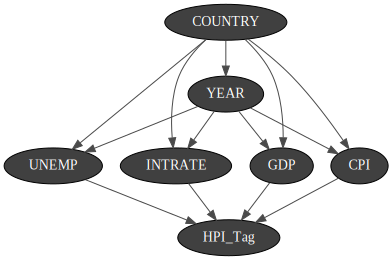

In [22]:
# call a Bayesian Network learner with the learning algorithm: the Hill Climbing algorithm
# different algorithm might lead to a different Bayesian Network
learner = gum.BNLearner(file_discr)
learner.useGreedyHillClimbing()
learner.addMandatoryArc("COUNTRY","YEAR") 
learner.addMandatoryArc("YEAR", "UNEMP") 
learner.addMandatoryArc("COUNTRY", "UNEMP") 
learner.addMandatoryArc("YEAR", "INTRATE") 
learner.addMandatoryArc("COUNTRY", "INTRATE") 
learner.addMandatoryArc("YEAR", "GDP") 
learner.addMandatoryArc("COUNTRY", "GDP")
learner.addMandatoryArc("YEAR", "CPI") 
learner.addMandatoryArc("COUNTRY", "CPI")
learner.addMandatoryArc("INTRATE","HPI_Tag") 
learner.addMandatoryArc("GDP","HPI_Tag") 
learner.addMandatoryArc("UNEMP","HPI_Tag") 
learner.addMandatoryArc("CPI","HPI_Tag") 
# learn the data
bn = learner.learnBN()
gnb.showBN(bn,size=100)

In [23]:
# extract the feature in the model
features = data_discr.drop(["HPI_Tag"], axis=1).columns.tolist()
features

['UNEMP', 'INTRATE', 'GDP', 'CPI', 'YEAR', 'COUNTRY']

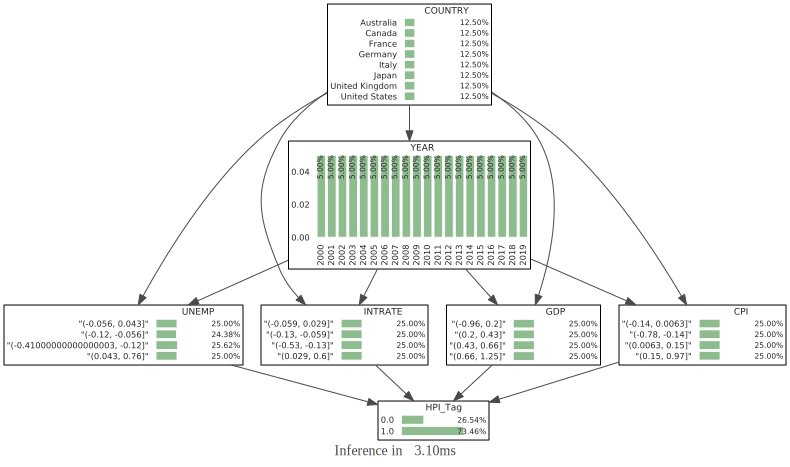

In [24]:
inference = bn_graphs.LazyPropagation(bn)
gnb.showInference(bn,inference, size=100)

Here above, we've built a Bayesian Network describing the probabilistic causal relationship between indicators. Moreover, both "COUNTRY" and "YEAR" are also counted into this network so that we could have a much clearer direction on which country was most affected by a specific indicator and in which year. The probabilities of the variables in each indicator are displayed in this model.

<div class="alert alert-block alert-success">
<b>Insight Note:</b> Generally, most of the house prices are increasing (73.43%) in these 8 countries from 2000 to 2019.
</div>

#### 3.2.3 Analysis & Visualisation

**Then let's initiate some questions to this network by calling the inference engine.**
* What if the HPI is 100% decreased (HPI_Tag set as 0)?

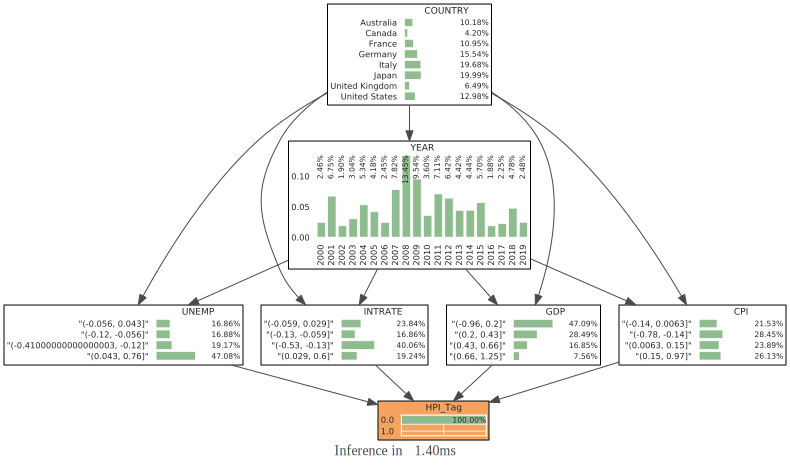

In [25]:
gnb.showInference( bn, inference, {'HPI_Tag':0} ,size=100)

<div class="alert alert-block alert-success">
<b>Insight Notes:</b>
    <li>In terms of country in this model, Japan and Italy stand out of other counties, this is truly reflecting its economic recession over the past decades due to the housing bubble.
    <li>It can be identified the decreased housing prices occurred mainly in 2008 which is the year of Global Financial Recession.
    <li>For the indicators, the probabilities in the unemployment rates, the interest rates and GDP are showing significant changes: the unemployment rate is increasing with the decreasing of the interest rates and GDP.
    <li>So we would say the housing prices could reflect the economic conditions in some ways specially regarding to the unemployment rate, the interest rate and GDP. But the impacts on different countries might vary.
</div>

* As the main focus for the stakeholder, how does the unemployment rate perform in the model? let's see when unemployment is high.

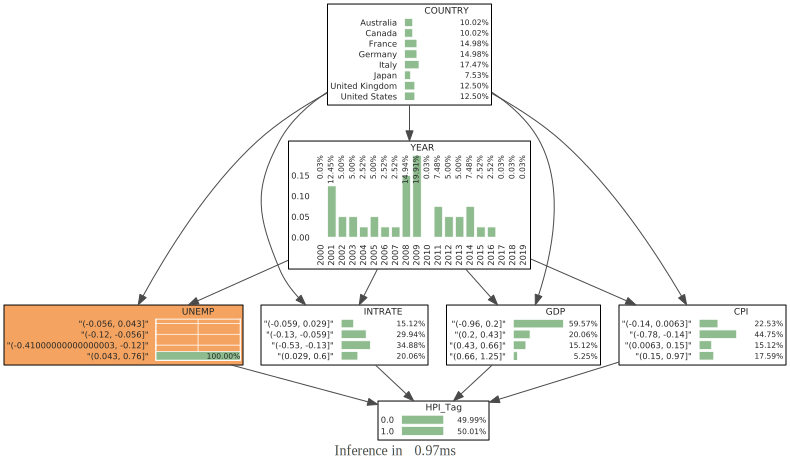

In [26]:
value = '"(0.043, 0.76]"'
gnb.showInference( bn, inference, { 'UNEMP' : value} ,size=100)

<div class="alert alert-block alert-success">
<b>Insight Notes:</b> 
    <li>It is apparently showing that the high unemployment rates occurred in 2001, 2008 and 2019 especially in European countries (Italy, Germany and France). This might due to the economic recession in these years. According to CNBC and Investopedia, the 8-month recession of 2001 was mainly caused by the "Internet Bubble" as well as 9-11 attack, and the Global Financial Crisis of 2008-2009 was due to the housing bubble.
    <li>It can be noticed that there was a rapid decrease in housing price because of the unemployment rates, the number of the decreasing HPI increased around 25% from 26.57% to 50.04%.
    <li>CPI was also affected as the majority of the changes was staying negatively in the range of (-0.78,-0.14] because there was less money in people's pockets due to layoffs.
    <li>However, it seems Japan was not affected a lot compared to other countries as shown in the model. But the truth is the data is showing the changes by years. Actually, Japan had been experiencing its "Lost Decade" before 2001, so we would say, there had been no sign of recovery since 1991 in Japan and it didn't mean Japan was not affected by the recession.
             
</div>

[Investopedia: A Review of Past Recessions](https://www.investopedia.com/articles/economics/08/past-recessions.asp)<br>
[CNBC Explains: Recession](https://www.cnbc.com/id/43563081)
<br>[Japan's Lost Decade](https://www.adb.org/sites/default/files/publication/159841/adbi-wp521.pdf)

* What about the interest rate? let's see when interest rate is high.

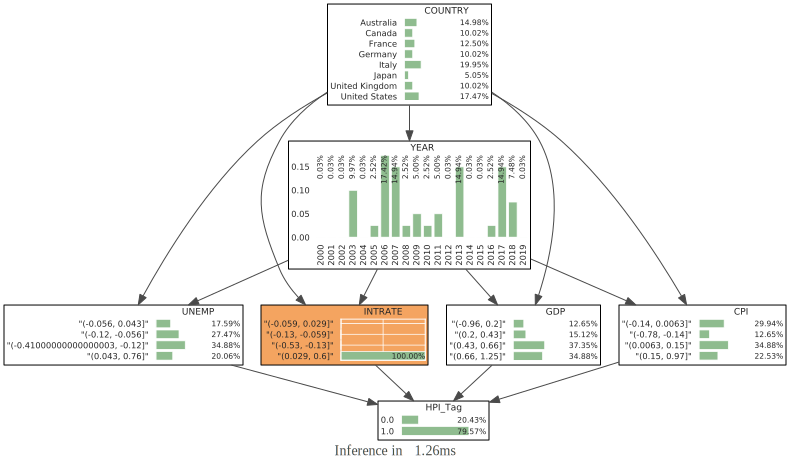

In [27]:
value = '"(0.029, 0.6]"'
gnb.showInference( bn, inference, { 'INTRATE' : value} ,size=100)

<div class="alert alert-block alert-success">
<b>Insight Notes:</b> 
It can be noticed that even the interest rate increases as we set, we still get an increased probability in HPI_Tag:1, which means the housing prices increases in some years (2006-2007, 2013, 2017). The causes might be found in the decreasing unemployment rate (around 80% are negative changes). But it's still too early to eliminate the impacts of the interest rates given our limited resources in this analysis.
    </div>

* what if the GDP or the CPI is high?

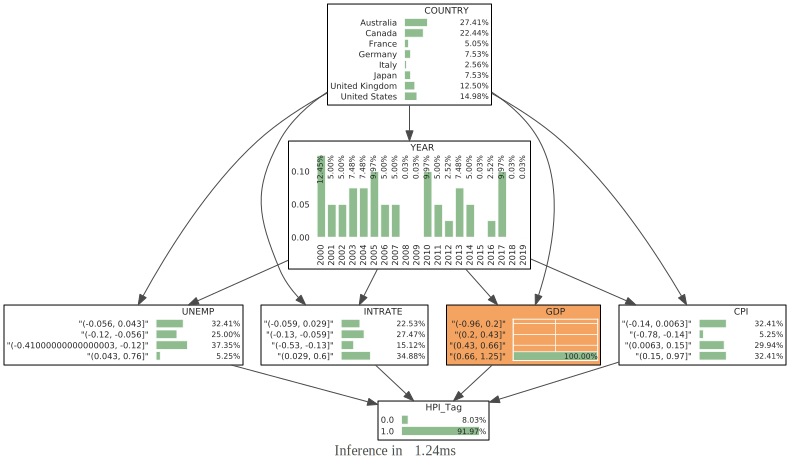

In [28]:
value = '"(0.66, 1.25]"'
gnb.showInference( bn, inference, { 'GDP' : value} ,size=100)

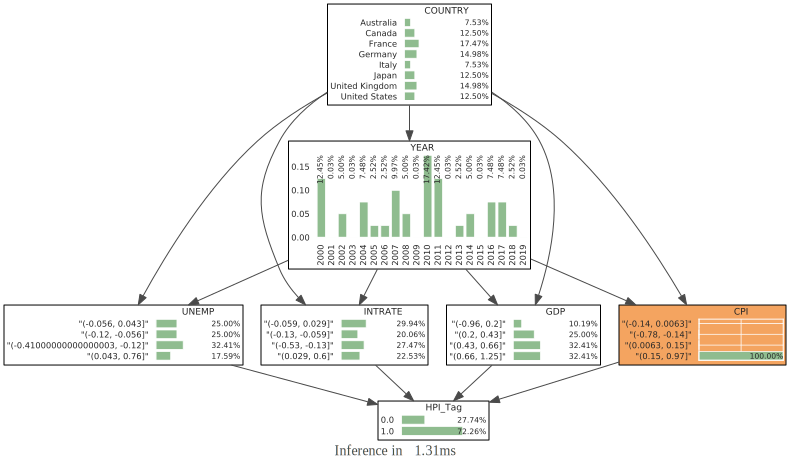

In [29]:
value = '"(0.15, 0.97]"'
gnb.showInference( bn, inference, { 'CPI' : value} ,size=100)

<div class="alert alert-block alert-success">
<b>Insight Notes:</b> not so much indications can be be found from the model in terms of GDP and CPI setting here.
    </div>

### 4. Insights
- Generally, the economic recession has great impacts on the housing market especially when it comes to the Global Financial Crisis (GFC) during 2007-2009 except for Germany due to its unique real estate financial policies and sophisticated rental market.
- The house price trend varies in different countries and it is not only related to the economic indicators such as interest rate, but also the investors' demand from domestic to international perspectives (e.g. Australia).
- Local fiscal stimulus can drive changes in the housing market (e.g. the US). Likewise, the housing-market indicators such as HPI can reflect the governmental financial policies which are made in accordance with the current economic conditions. So, we would say there is a mutual effect between the housing market and the economic conditions.
- The house price can reflect the socio-economic conditions in the unemployment rate, the interest rate and GDP particularly. When the house price is decreasing, the unemployment rate usually shows increasing while the interest rate and GDP are decreasing, but not vice versa in this analysis.
- As concerned by the stakeholder, YES, the unemployment rate has significant influences on the housing market as well as CPI. When the unemployment rate is high, the CPI and the house price will usually decrease.
- Finally, the housing market indicators can be provided for forecasting the economic conditions to some extent. The house prices can be the reflection of the current state of the economy in a country, and some indicators such as the interest rate, the unemployment rate are both housing market indicators and the socio-economic indicators, and they could be interacted with each other. But regarding the real estate investment decision, it should be emphasised that the housing prices are not only affected by the socio-economic situations in a country, but also related to the house itself (the location, the area, the education catchment, the house type, etc.), the investment policy including but not limited to the taxes and even the local buying culture.

**Limitations and Future Work**
- The indicators selected in this anlysis are limited and more indicators can be involved in to achieve a more accurate analysis.
- Analysis results will vary from country to country, so once you have a target country, it might be better to focus on the specific situations in that country and take more factors into account in the analysis.
- The analysis results may also be different from each other due to the different techniques and algorithms applied in the analysis. So, it should be better to evaluate the result using professional methods in the future to better support the decision making.

### Reference:
Voigtländer, M. (2014). The stability of the German housing market. Journal of Housing and the Built Environment, 29(4), 583–594. https://doi.org/10.1007/s10901-013-9366-1